In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from datetime import datetime

In [2]:
df = pd.read_csv('AAPL.csv')
# date_time_obj = datetime.strptime(date_time_str, '%d/%m/%y %H:%M:%S')

# cast date strings into date objects
df['Date'] = df['Date'].apply(lambda x: x[2:])
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%y-%m-%d'))
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-06-12,128.190002,128.330002,127.110001,127.169998,117.200966,36886200
1,2015-06-15,126.099998,127.239998,125.709999,126.919998,116.970581,43988900
2,2015-06-16,127.029999,127.849998,126.370003,127.599998,117.597267,31494100
3,2015-06-17,127.720001,127.879997,126.739998,127.300003,117.320793,32918100
4,2015-06-18,127.230003,128.309998,127.220001,127.879997,117.855324,35407200


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1259 non-null   datetime64[ns]
 1   Open       1259 non-null   float64       
 2   High       1259 non-null   float64       
 3   Low        1259 non-null   float64       
 4   Close      1259 non-null   float64       
 5   Adj Close  1259 non-null   float64       
 6   Volume     1259 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 69.0 KB


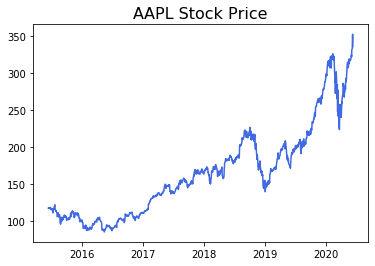

In [4]:
dates = df['Date']
prices = df['Adj Close']
plt.plot(dates, prices, color='royalblue')
plt.title('AAPL Stock Price', size='16')
plt.show()

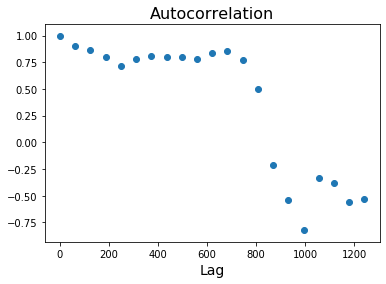

In [5]:
# Autocorrelation
autocorrelation = []

lags_list = []
lags = 20
for lag in range(1, int(len(prices)), int(len(prices)/lags)):
    correlation = np.corrcoef(prices[:-lag],
                             prices[lag:])[0,1]
    autocorrelation.append(correlation)
    lags_list.append(lag)

plt.scatter(lags_list, autocorrelation)
plt.title('Autocorrelation', size='16')
plt.xlabel('Lag', size='14')
plt.show()

In [6]:
# Autocorrelation Function Implementation

def acf(data, max_lags):
    """
    Inputs:
    data- vector
    max_lags- integer
    
    Returns:
    Variance of input data (float)
    Autocovariance vector
    Autocorrelation vector
    
    """
    sig2 = statistics.variance(data)
    acv = []
    acr = []
    
    # Autocovariance
    for k in range(max_lags+1):
        if k == 0: # 0 lag
            acv.append(np.cov(data, data)[0,1]) # covariance with itself
        else:
            acv.append(np.cov(data[k:], data[:-k])[0,1])
            
    # Autocorrelation
    for cov in acv:
        acr.append(cov / sig2)
    
    return sig2, acv, acr
    

In [7]:
def durbin_levinson(g, max_lags):
    """
    Creates psi matrix used to calculate coefficients
    PACV (Partial Auto-Correlation Function) is on the main diagonal
    
    Inputs:
    g- autocovariance vector
    max_lags- number of 'p' lags
    
    """
    
    phi = [] # AR(p) parameters/coefficients
    psi = [[0 for col in range(max_lags+1)] for row in range(max_lags+1)] # psi matrix   
    
    r = [g[0]] # store residuals?
    
    for k in range(1,max_lags+1):
        
        # update main diagonal
        total = 0
        for j in range(1,k): # for each 'j' col in 'k' (lag) row
            total += psi[k-1][j] * g[k-j]
        a = (g[k] - total) / r[k-1]
        psi[k][k] = a
        
        # filling out left side of diagonal --> does nothing the 1st iteration (range 1,1)
        for j in range(1,k):
            psi[k][j] = psi[k-1][j] - a * psi[k-1][k-j]
        
        # updates to r list
        r.append(r[k-1] * (1 - a**2))
        
#     print(np.matrix(psi))
    
    return psi
            
            

In [8]:
example = [1,2,3,5,4,6,5,7,7,6,7,9,6,7,6,8,8,9,10,12]
mean = sum(example) / len(example)

for i in range(len(example)):
    example[i] = example[i] - mean
    
var, autocovar, autocor = acf(example, 3)
durbin_levinson(autocovar, 3)

[[0, 0, 0, 0],
 [0, 0.6627101879327398, 0, 0],
 [0, 0.536139416645621, 0.1909896265242943, 0],
 [0, 0.5446493085420276, 0.2148782981767119, -0.04455682777789046]]

In [9]:

predictions = []

psi_mat = durbin_levinson(autocovar, 3)
for row_idx in range(1, len(psi_mat)):
    total = 0
    coef_idx = 1
    y_idx = -1
    while coef_idx <= 3: # unneeded calculations (0 as parameter)
        total += psi_mat[row_idx][coef_idx] * example[y_idx]
        coef_idx += 1
        y_idx -= 1
    predictions.append(total + mean)
    
# pretty print
lag_count = 1
for prediction in predictions:
    print("Lag " + str(lag_count) + ":", prediction)
    lag_count += 1
    

    

Lag 1: 10.111177052423344
Lag 2: 10.089943388702938
Lag 3: 10.107750249049003


In [10]:
def train(y, max_lags):
    
    # zero mean data
    data = y.copy()
    mu = sum(data) / len(data)
    for i in range(len(data)):
        data[i] = data[i] - mu
        
    # autocorrelation
    variance, autocov, autocor = acf(data, max_lags)
    
    # create coefficient matrix
    psi_mat = durbin_levinson(autocov, max_lags)
    
    return data, mu, psi_mat
    
    

In [12]:
def forecast(data, mu, psi, max_lags):
    """
    Input data is zero-meaned
    
    Output: forecasts the next y
    
    """
    predictions = []

    for row_idx in range(1, len(psi)): # predict each lag
        total = 0
        idx = 1
        while idx <= max_lags: # unneeded calculations (0 as parameter)
            total += psi[row_idx][idx] * data[-idx]
            idx += 1
        predictions.append(total + mu)
    
    return predictions[-1] # return first forecast step
            
   

In [39]:
example = list(prices)
example[-5:]

[331.5, 333.459991, 343.98999, 352.839996, 335.899994]

In [18]:
# for multiple steps, need to retrain in order to predict next step

def train_and_forecast_multiple(y, max_lags, steps=2):
    
    step_counter = steps # instantiate step counter
    
    # train the first time (step 1)
    data, mu, psi_mat = train(y, max_lags)
    # forecast the first time (step 1)
    prediction = forecast(data, mu, psi_mat, max_lags)
    
    dwp = list(y).copy() # data with predictions
    prediction_history = [prediction] # store predictions
    dwp.append(prediction) # add 1st prediction to data
    
    # de-increment step_counter (made 1st prediction)
    step_counter -= 1
    
    # train and predict multiple times
    while step_counter > 0:
        # train and predict
        data, mu, psi_mat = train(dwp, max_lags)
        prediction = forecast(data, mu, psi_mat, max_lags)
        
        # add to lists
        prediction_history.append(prediction)
        dwp.append(prediction)
        
        step_counter -= 1 # de-increment step counter    
    
    return prediction_history
        

In [38]:
# Forecast the next 5 days
train_and_forecast_multiple(example, 150, 5)

[299.4931166976599,
 250.9852401658889,
 190.95559032106846,
 208.21870707478143,
 183.17743894133244]